In [1]:
%matplotlib inline
from matplotlib import pyplot as plt 
import kinetics_simulator as ks
import numpy as np

In [2]:
# Define a reaction:

rxn = \
"""
G6P = 1000
F6P = 0
F16P = 0
DHAP = 0
G3P = 0
_13BPG = 0
_3PG = 0
_2PG = 0
PEP = 0

CO2 = 0
Ru5P= 0
R5P = 0
X5P = 0
S7P = 0
E4P = 0
NADP = 0
NADPH = 0
NAD = 1000
NADH = 1
ADP = 100
ATP = 1000
pyruvate = 0
lactate = 0

# oxidative pentose phosphate
G6P + NADP + NADP -> Ru5P + NADPH + NADPH + CO2; 1

# Non-oxidative pentose phosphate
Ru5P -> R5P; 1000
R5P -> Ru5P; 1000
Ru5P -> X5P; 1000
X5P -> Ru5P; 1000
R5P + X5P -> G3P + S7P; 1000
G3P + S7P -> R5P + X5P; 1000
X5P + E4P -> G3P + F6P; 1000
G3P + F6P -> X5P + E4P; 1000
S7P + G3P -> F6P + E4P; 1000
F6P + E4P -> S7P + G3P; 1000

# Glycolysis
G6P -> F6P; 1000
F6P -> G6P; 1000

F16P -> DHAP + G3P; 1000
DHAP + G3P -> F16P; 1000

DHAP -> G3P; 1000
G3P -> DHAP; 1000

G3P + NAD -> _13BPG + NADH; 1000
_13BPG + NADH -> G3P + NAD; 1000

_13BPG + ADP -> _3PG + ATP; 1000
_3PG + ATP -> _13BPG + ADP; 1000

_3PG -> _2PG; 1000
_2PG -> _3PG; 1000

_2PG -> PEP; 1000
PEP -> _2PG; 1000

# gluconeogenesis/glycolysis (flip PFK/FBPase and pyruvate dehydorg)
F6P + ATP -> F16P + ADP; 1 
PEP + ADP -> pyruvate + ATP; 1
#F16P -> F6P; 1
#pyruvate + 2*ATP -> PEP + 2*ADP; 1

# aerobic respiration
#pyruvate + 9*ADP -> 3*CO2 + 9*ATP; 1
#NADH -> NAD + 2*ATP; 1

# anaerobic respiration
pyruvate + NADH -> lactate + NAD; 1

# metabolism is happening
ATP -> ADP; 800
NADPH -> NADP; 10000
R5P -> CO2; 100
"""

### Run reaction as a stochastic Gillespie simulation

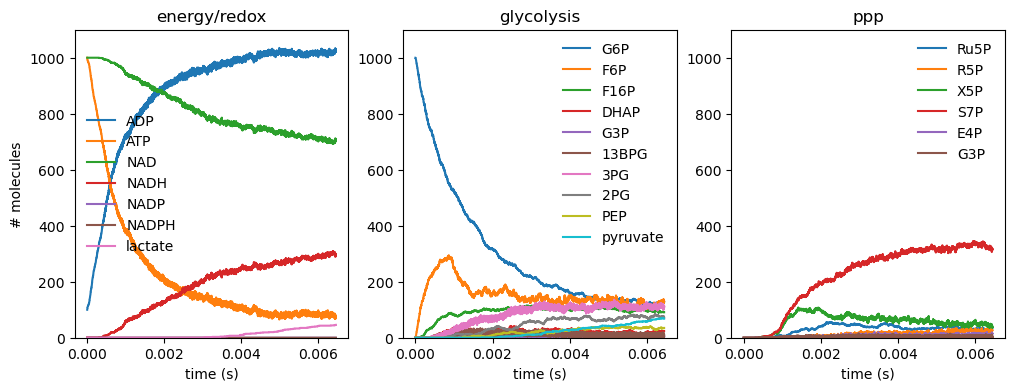

In [3]:
# create markov model
g = ks.Gillespie(rxn)

# Run 2,000 time steps (will correspond to ~2 seconds)
for i in range(200000):
    g.take_step()

fig, ax = plt.subplots(1,3,figsize=(12,4))
    
# Plot result
ax[0].set_title("energy/redox")
ax[0].plot(g.conc_history.time,g.conc_history.ADP,label="ADP")
ax[0].plot(g.conc_history.time,g.conc_history.ATP,label="ATP")
ax[0].plot(g.conc_history.time,g.conc_history.NAD,label="NAD")
ax[0].plot(g.conc_history.time,g.conc_history.NADH,label="NADH")
ax[0].plot(g.conc_history.time,g.conc_history.NADP,label="NADP")
ax[0].plot(g.conc_history.time,g.conc_history.NADPH,label="NADPH")
ax[0].plot(g.conc_history.time,g.conc_history.lactate,label="lactate")

ax[1].set_title("glycolysis")
ax[1].plot(g.conc_history.time,g.conc_history.G6P,label="G6P")
ax[1].plot(g.conc_history.time,g.conc_history.F6P,label="F6P")
ax[1].plot(g.conc_history.time,g.conc_history.F16P,label="F16P")
ax[1].plot(g.conc_history.time,g.conc_history.DHAP,label="DHAP")
ax[1].plot(g.conc_history.time,g.conc_history.G3P,label="G3P")
ax[1].plot(g.conc_history.time,g.conc_history._13BPG,label="13BPG")
ax[1].plot(g.conc_history.time,g.conc_history._3PG,label="3PG")
ax[1].plot(g.conc_history.time,g.conc_history._2PG,label="2PG")
ax[1].plot(g.conc_history.time,g.conc_history.PEP,label="PEP")
ax[1].plot(g.conc_history.time,g.conc_history.pyruvate,label="pyruvate")

ax[2].set_title("ppp")
ax[2].plot(g.conc_history.time,g.conc_history.Ru5P,label="Ru5P")
ax[2].plot(g.conc_history.time,g.conc_history.R5P,label="R5P")
ax[2].plot(g.conc_history.time,g.conc_history.X5P,label="X5P")
ax[2].plot(g.conc_history.time,g.conc_history.S7P,label="S7P")
ax[2].plot(g.conc_history.time,g.conc_history.E4P,label="E4P")
ax[2].plot(g.conc_history.time,g.conc_history.G3P,label="G3P")

ax[0].set_ylabel("# molecules")
for i in range(3):
    ax[i].legend(frameon=False)
    ax[i].set_xlabel("time (s)")
    ax[i].set_ylim((0,1100))
    
None